<a href="https://colab.research.google.com/github/Jyothiraditya135/Some-Codes/blob/main/TruthSeekersHackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

print(files.upload())

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c truth-seekers

In [ ]:
!unzip /content/truth-seekers.zip

In [ ]:
train_dataset = '/content/train.csv'
test_dataset = '/content/test.csv'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy

In [ ]:
tr_df = pd.read_csv(train_dataset)
te_df = pd.read_csv(test_dataset)

In [ ]:
tr_df.isnull().sum()

In [ ]:
def preprocess_text(text_data):
	preprocessed_text = []

	for sentence in tqdm(text_data):
		sentence = re.sub(r'[^\w\s]', '', sentence)
		preprocessed_text.append(' '.join(token.lower()
								for token in str(sentence).split()
								if token not in stopwords.words('english')))

	return preprocessed_text


In [ ]:
preprocessed_review = preprocess_text(tr_df['all'])
tr_df['all'] = preprocessed_review

100%|██████████| 9550/9550 [10:18<00:00, 15.44it/s]


<Axes: xlabel='label', ylabel='count'>

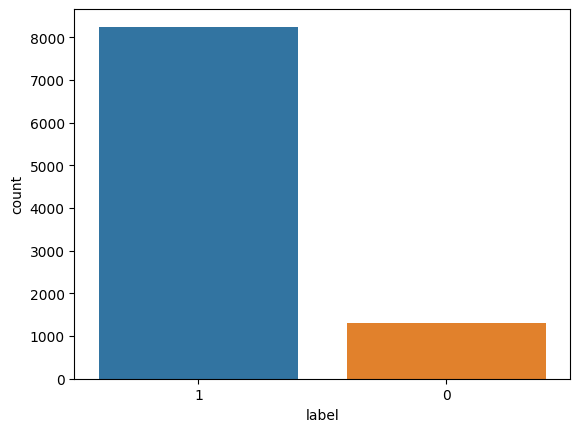

In [ ]:
sns.countplot(data=tr_df, x='label', order=tr_df['label'].value_counts().index)

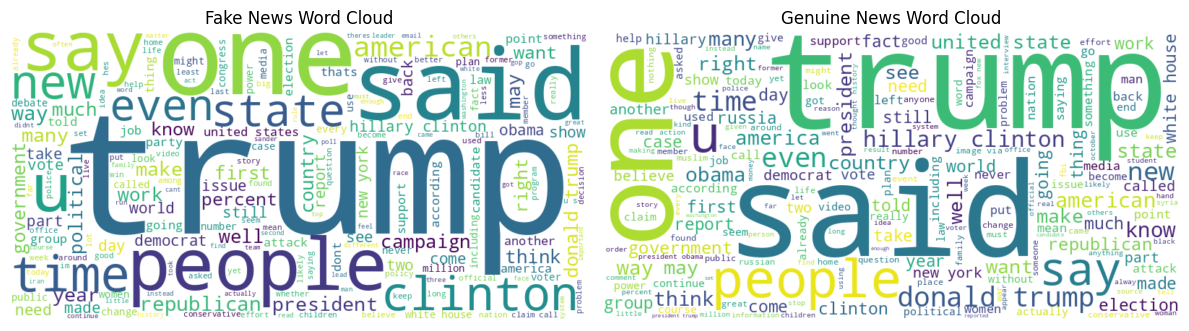

In [ ]:
fake_text = tr_df[tr_df['label'] == 0]['all'].str.cat(sep=' ')
true_text = tr_df[tr_df['label'] == 1]['all'].str.cat(sep=' ')
fake_wordCloud = WordCloud(width=800, height=400, background_color='white').generate(fake_text)
true_wordCloud = WordCloud(width=800, height=400, background_color='white').generate(true_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(fake_wordCloud, interpolation='bilinear')
plt.title('Fake News Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(true_wordCloud, interpolation='bilinear')
plt.title('Genuine News Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()





In [ ]:
def get_top_n_words(corpus, n=None):
  vec = CountVectorizer().fit(corpus)
  bow = vec.transform(corpus)
  sum_of_words = bow.sum(axis=0)
  frequency = [(word, sum_of_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  frequency = sorted(frequency, key=lambda x : x[1], reverse=True)
  return frequency[:n]

top_words = get_top_n_words(tr_df['all'], 20)
new_df = pd.DataFrame(top_words, columns=['Word', 'Count'])

new_df.groupby('Word').sum()['Count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel='Top Words',
    ylabel='Count',
    title='Bar Plot of Top Words'
)



In [ ]:
spacy_eng = spacy.load("en_core_web_sm")

In [ ]:
def tokenizer_eng(text):
  return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

In [ ]:
def tokenizer(df):
  for i in range(df.shape[0]):
    df['all'][i] = tokenizer_eng(df['all'][i])

In [ ]:
tokenizer(tr_df)
tokenizer(te_df)

In [ ]:
tr_df['all'][0]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
import torch
import torchvision.transforms as transforms

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In [ ]:
import numpy as np
from numpy import asarray
import pandas as pd

glove_embeddings = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    glove_embeddings[word] = vector

def sentence_vector(tokens):
  vectors = []
  for token in tokens:
    if token in glove_embeddings:
      vectors.append(glove_embeddings[token])
    else:
      vectors.append(np.zeros(100))
  return np.mean(vectors, axis=0)

tr_df['sentence_vector'] = tr_df['all'].apply(sentence_vector)
te_df['sentence_vector'] = te_df['all'].apply(sentence_vector)

In [ ]:
tr_df['sentence_vector'].head(10)

In [ ]:
tr_df.head(10)

In [ ]:
tr_df.drop(columns = ['id', 'title', 'text', 'all'])


In [ ]:
te_df.drop(columns = ['id', 'title', 'text', 'all'])

In [ ]:
print(type(tr_df['sentence_vector'].values))

In [ ]:
tr_df['sentence_vector'] = tr_df['sentence_vector'].dtype(np.float32)
tr_df['label'] = tr_df['label'].dtype(np.float32)
te_df['sentence_vector'] = te_df['sentence_vector'].dtype(np.float32)
te_df['label'] = tr_df['label'].dtype(np.float32)

In [ ]:
X_train = torch.tensor(tr_df['sentence_vector'].values, dtype= torch.float32)
Y_train = torch.tensor(tr_df['label'].values, dtype=torch.float32)
X_test = torch.tensor(te_df['sentence_vector'].values, dtype=torch.float32)
Y_test = torch.tensor(te_df['label'].values, dtype=torch.float32)
print

In [ ]:
model = LogisticRegression()
